# Import necessary libraries:

In [7]:
from keras.saving.save import load_model
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore")

# Load the model:

In [8]:
model = load_model("models/best_encoder.h5", compile=False)

# Load the data:

In [9]:
data = pd.read_pickle("datasets/combined-u/combined_alpha(0.005).pkl")
data_train = pd.read_pickle("datasets/combined-u/combined_alpha(0.005)_train_kmeans.pkl")

# Encode the data:

In [10]:
encoded_data_all = model.predict(data)
encoded_data_train = model.predict(data_train)

38/38 [==============================] - 0s 919us/step


# Use Average Silhouette method to find the optimal number of clusters using KMeans:

In [20]:
# Define clustering loop
max_clusters = 30
silhouette = np.zeros(max_clusters)

for n_clusters in range(2, max_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(encoded_data_train)
    labels = kmeans.labels_
    silhouette[n_clusters] = metrics.silhouette_score(encoded_data_train, labels, metric='euclidean')

# Determine the optimal number of clusters
optimal_n_clusters = np.argmax(silhouette)
print("Optimal number of clusters:", optimal_n_clusters)

Optimal number of clusters: 12


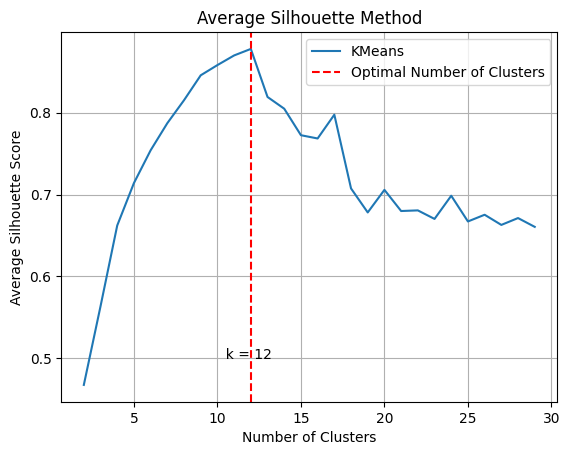

In [21]:
# Plot the silhouette scores
plt.plot(np.arange(2, max_clusters), silhouette[2:], label="KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.title("Average Silhouette Method")

# annotate the optimal number of clusters with vertical dotted line and write the number of clusters
plt.axvline(x=optimal_n_clusters,
            linestyle="--" ,
            color="red",
            label='Optimal Number of Clusters')
plt.annotate('  k = %d' % optimal_n_clusters,
             xy=(optimal_n_clusters-2, 0.5),
             xytext=(optimal_n_clusters-2, 0.5)
)

plt.grid()
plt.legend()
plt.show()

# Use Elbow method to find the optimal number of clusters using KMeans:

In [22]:
# Define range of cluster numbers to try
max_clusters = 30

# Calculate WCSS for each cluster number using KMeans
wcss_kmeans = []
for n_clusters in range(2, max_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(encoded_data_train)
    wcss_kmeans.append(kmeans.inertia_)

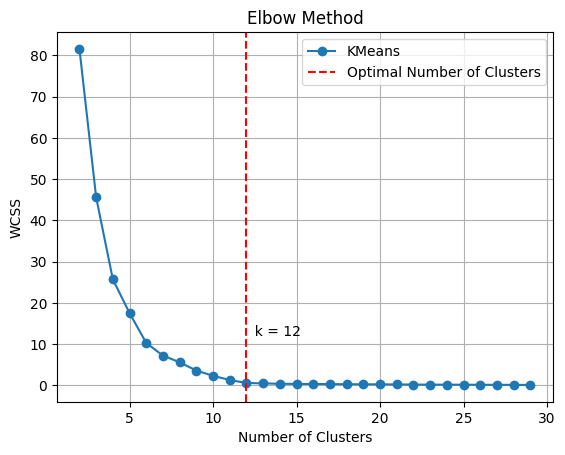

In [23]:
# Plot the WCSS for each cluster number
plt.plot(range(2, max_clusters), wcss_kmeans, marker='o', label="KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")

# annotate the optimal number of clusters with vertical dotted line and write the number of clusters
plt.axvline(x=optimal_n_clusters,
            linestyle="--" ,
            color="red",
            label='Optimal Number of Clusters')
plt.annotate('  k = %d' % optimal_n_clusters,
             xy=(optimal_n_clusters, optimal_n_clusters),
             xytext=(optimal_n_clusters, optimal_n_clusters)
)

plt.grid()
plt.legend()
plt.show()

# Train kmeans with the optimal number of clusters:

In [11]:
optimal_n_clusters = 12
kmeans = KMeans(n_clusters=optimal_n_clusters, init="k-means++", random_state=42)
kmeans.fit(encoded_data_train)

KMeans(n_clusters=12, random_state=42)

In [12]:
clusters = kmeans.predict(encoded_data_all)

In [13]:
print("Number of users in each cluster\nsorted by cluster number:")
print(pd.Series(clusters).value_counts().sort_index(ascending=True).reset_index(drop=True))

Number of users in each cluster
sorted by cluster number:
0     1130
1      163
2      338
3     1397
4      437
5      499
6      371
7      855
8      141
9      515
10     135
11      59
dtype: int64


# Save the Kmeans model with the optimal number of clusters:

In [30]:
joblib.dump(kmeans, "models/kmeans.pkl")

['models/kmeans.pkl']

# Save the users of each cluster:

In [20]:
# save each cluster in a separate dataframe and file
for i in range(12):
    cluster_users = pd.DataFrame(columns=["cluster", "UID"])
    for j in range(len(clusters)):
        if clusters[j] == i:
            cluster_users = cluster_users.append({"cluster": clusters[j], "UID": data.index[j]+1}, ignore_index=True)
    # cluster_users = cluster_users.set_index("UID")
    # cluster_users.drop(columns=["cluster"], inplace=True)
    cluster_users.to_pickle("datasets/clusters/cluster_" + str(i) + ".pkl")


In [22]:
# print saved clusters
for i in range(12):
    a = pd.read_pickle("datasets/clusters/cluster_" + str(i) + ".pkl")
    print("Cluster", i)
    print(a["UID"])
    print()

Cluster 0
0          2
1          4
2         13
3         17
4         19
        ... 
1125    6014
1126    6016
1127    6020
1128    6032
1129    6033
Name: UID, Length: 1130, dtype: object

Cluster 1
0        38
1        41
2        92
3       122
4       162
       ... 
158    5906
159    5956
160    5959
161    5985
162    5992
Name: UID, Length: 163, dtype: object

Cluster 2
0        10
1        16
2        30
3        55
4        62
       ... 
333    5945
334    5966
335    5991
336    5995
337    6017
Name: UID, Length: 338, dtype: object

Cluster 3
0          3
1          5
2          8
3          9
4         12
        ... 
1392    6023
1393    6024
1394    6030
1395    6034
1396    6040
Name: UID, Length: 1397, dtype: object

Cluster 4
0        21
1        22
2        46
3        49
4        57
       ... 
432    5932
433    5935
434    5949
435    5957
436    5964
Name: UID, Length: 437, dtype: object

Cluster 5
0        11
1        24
2        28
3        32
4        37
 

In [52]:
# create similarity matrix for all users and clusters in this form
all_users_cluster = pd.DataFrame(columns=["UID", "cluster"])
'''
        cluster
        0   1   2
UID 1   1   0   0
    2   0   1   0
    3   0   0   1
'''
for i in range(len(clusters)):
    all_users_cluster = all_users_cluster.append({"UID": data.index[i]+1, "cluster": clusters[i]}, ignore_index=True)

all_users_cluster = all_users_cluster.set_index("UID")
all_users_cluster = pd.get_dummies(all_users_cluster["cluster"], prefix="cluster")
all_users_cluster = all_users_cluster.groupby(all_users_cluster.index).sum()
all_users_cluster = all_users_cluster.astype("int8")

In [53]:
all_users_cluster.to_pickle("datasets/matrices/all_users_cluster.pkl")

In [54]:
print(all_users_cluster)

      cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
UID                                                                      
1             0          0          0          0          0          0   
2             1          0          0          0          0          0   
3             0          0          0          1          0          0   
4             1          0          0          0          0          0   
5             0          0          0          1          0          0   
...         ...        ...        ...        ...        ...        ...   
6036          0          0          0          0          0          1   
6037          0          0          0          0          0          0   
6038          0          0          0          0          0          0   
6039          0          0          0          0          0          0   
6040          0          0          0          1          0          0   

      cluster_6  cluster_7  cluster_8